In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

def load_data(filename):
    # Load the data
    data = pd.read_csv(filename)
    
    # Separate features and target
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    
    # Convert categorical variables to numerical
    X = pd.get_dummies(X, drop_first=True)
    
    # Convert y to -1 and 1
    y = (y == 'yes').astype(int) * 2 - 1
    
    return X.values, y.values

class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.alpha = None
        self.left_prediction = None
        self.right_prediction = None

def build_stump(X, y, weights):
    n_samples, n_features = X.shape
    best_stump = DecisionStump()
    min_error = float('inf')

    for feature in range(n_features):
        feature_values = X[:, feature]
        thresholds = np.unique(feature_values)
        for threshold in thresholds:
            left_mask = feature_values <= threshold
            right_mask = ~left_mask

            left_prediction = 1 if np.sum(weights[left_mask] * y[left_mask]) > 0 else -1
            right_prediction = 1 if np.sum(weights[right_mask] * y[right_mask]) > 0 else -1

            predictions = np.ones(n_samples)
            predictions[left_mask] = left_prediction
            predictions[right_mask] = right_prediction

            error = np.sum(weights * (predictions != y))

            if error < min_error:
                min_error = error
                best_stump.feature_index = feature
                best_stump.threshold = threshold
                best_stump.left_prediction = left_prediction
                best_stump.right_prediction = right_prediction

    return best_stump, min_error

def stump_predict(X, stump):
    n_samples = X.shape[0]
    predictions = np.ones(n_samples)
    left_mask = X[:, stump.feature_index] <= stump.threshold
    predictions[left_mask] = stump.left_prediction
    predictions[~left_mask] = stump.right_prediction
    return predictions

def adaboost(X, y, T):
    n_samples, n_features = X.shape
    weights = np.ones(n_samples) / n_samples
    
    stumps = []
    stump_errors = []
    
    for t in range(T):
        stump, error = build_stump(X, y, weights)
        
        error = np.clip(error, 1e-15, 1 - 1e-15)
        
        stump.alpha = 0.5 * np.log((1 - error) / error)
        
        predictions = stump_predict(X, stump)
        weights *= np.exp(-stump.alpha * y * predictions)
        weights /= np.sum(weights)
        
        stumps.append(stump)
        stump_errors.append(error)
        
        if t % 10 == 0:
            train_error = np.mean(adaboost_predict(X, stumps) != y)
            print(f"Iteration {t+1}/{T}, Train Error: {train_error:.4f}")
    
    return stumps, stump_errors

def adaboost_predict(X, stumps):
    n_samples = X.shape[0]
    predictions = np.zeros(n_samples)
    for stump in stumps:
        predictions += stump.alpha * stump_predict(X, stump)
    return np.sign(predictions)

Training data shape: (4999, 42)
Test data shape: (4999, 42)
Iteration 1/500, Train Error: 0.1088
Iteration 11/500, Train Error: 0.1050
Iteration 21/500, Train Error: 0.1004
Iteration 31/500, Train Error: 0.1020
Iteration 41/500, Train Error: 0.0982
Iteration 51/500, Train Error: 0.0994
Iteration 61/500, Train Error: 0.1008
Iteration 71/500, Train Error: 0.1004
Iteration 81/500, Train Error: 0.0994
Iteration 91/500, Train Error: 0.0992
Iteration 101/500, Train Error: 0.0990
Iteration 111/500, Train Error: 0.0984
Iteration 121/500, Train Error: 0.0990
Iteration 131/500, Train Error: 0.0968
Iteration 141/500, Train Error: 0.0974
Iteration 151/500, Train Error: 0.0964
Iteration 161/500, Train Error: 0.0976
Iteration 171/500, Train Error: 0.0964
Iteration 181/500, Train Error: 0.0956
Iteration 191/500, Train Error: 0.0952
Iteration 201/500, Train Error: 0.0956
Iteration 211/500, Train Error: 0.0946
Iteration 221/500, Train Error: 0.0938
Iteration 231/500, Train Error: 0.0948
Iteration 241/5

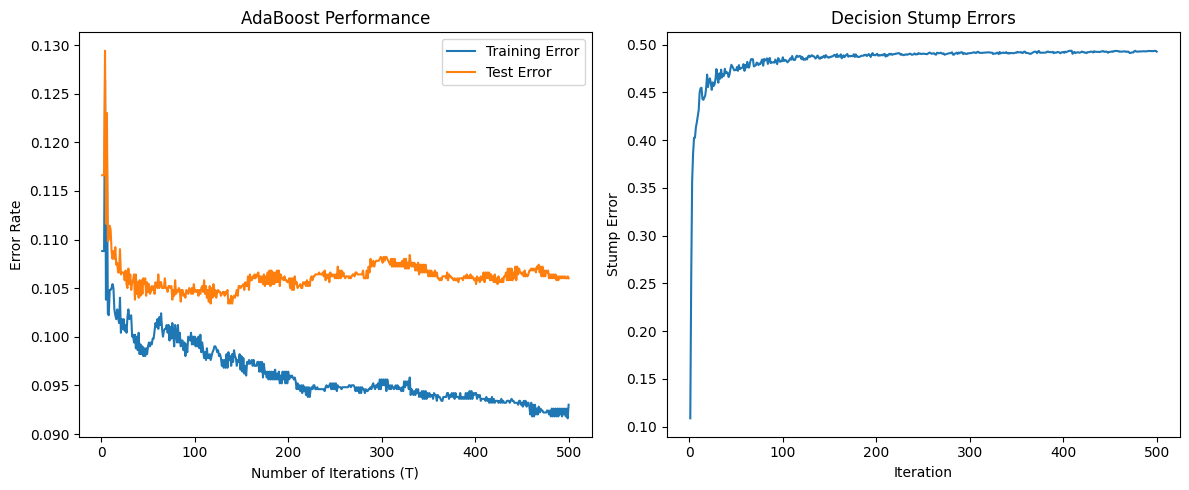

In [2]:
# Load and preprocess data
X_train, y_train = load_data('train_bank.csv')
X_test, y_test = load_data('test_bank.csv')

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Run AdaBoost
T = 500
stumps, stump_errors = adaboost(X_train, y_train, T)

# Calculate errors
train_errors = []
test_errors = []

for t in range(1, T + 1):
    train_preds = adaboost_predict(X_train, stumps[:t])
    test_preds = adaboost_predict(X_test, stumps[:t])
    
    train_error = np.mean(train_preds != y_train)
    test_error = np.mean(test_preds != y_test)
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    if t % 50 == 0:
        print(f"Iteration {t}, Train Error: {train_error:.4f}, Test Error: {test_error:.4f}")

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, T + 1), train_errors, label='Training Error')
plt.plot(range(1, T + 1), test_errors, label='Test Error')
plt.xlabel('Number of Iterations (T)')
plt.ylabel('Error Rate')
plt.title('AdaBoost Performance')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, T + 1), stump_errors)
plt.xlabel('Iteration')
plt.ylabel('Stump Error')
plt.title('Decision Stump Errors')

plt.tight_layout()
plt.show()